In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# read data
df = pd.read_excel("cleaned_data/store_data.xls")
furniture = df.loc[df['Category'] == 'Furniture']
furniture.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310


In [3]:
# time stamp
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [4]:
# drop unwanted cols
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

# check missing value
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [5]:
# groupby date and sales
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [6]:
# indexing with time series data
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [7]:
y = furniture['Sales'].resample('MS').mean()
#y

In [8]:
y['2017']

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

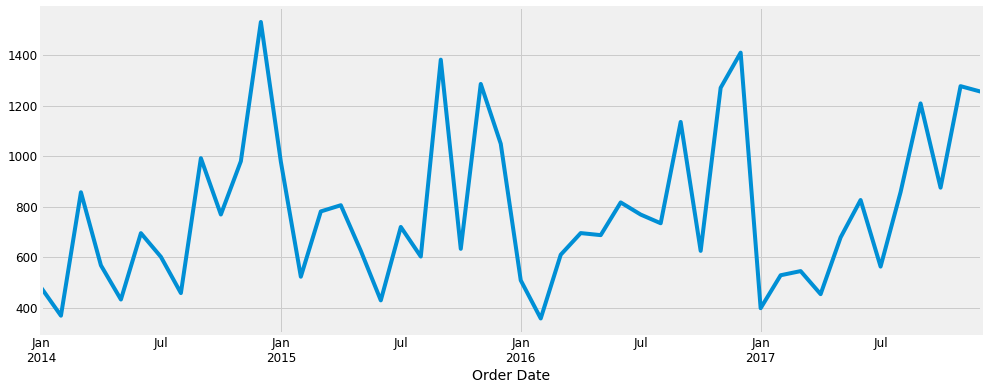

In [9]:
y.plot(figsize=(15, 6))
plt.show()

- The time series has seasonality pattern.
- There is always an **upward** trend within any single year with a couple of low months in the mid of the year.

### Time Series Decomposition
Decompose time series into three distinct compinents:
- trend
- seasonality
- noise

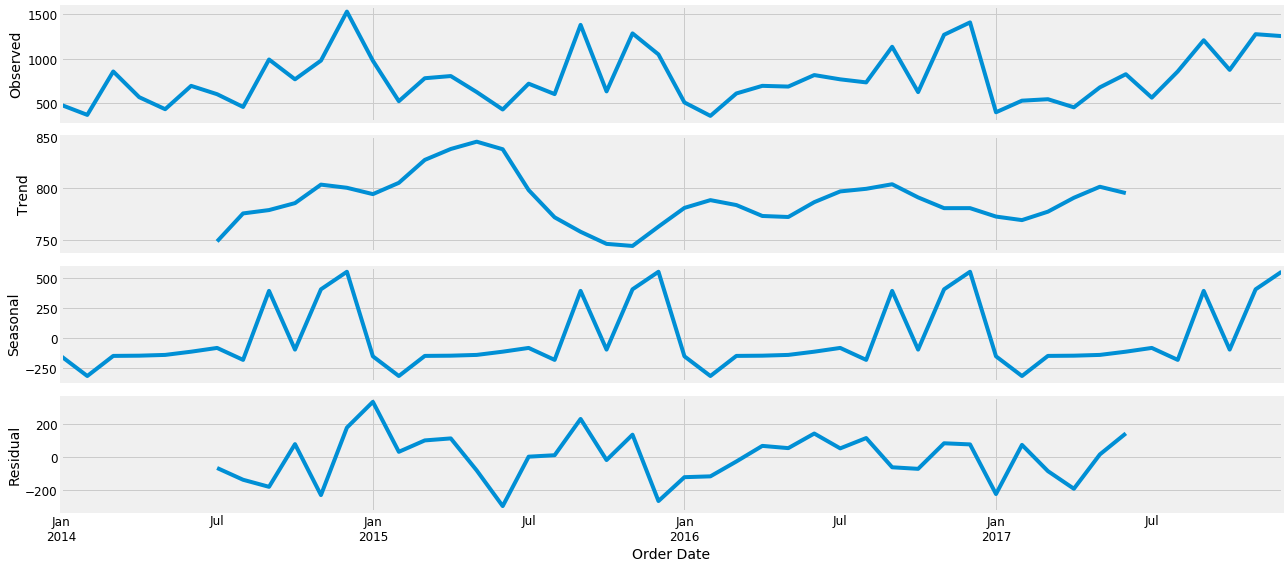

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The sales of furniture were impacted by the seasonality.

### Time Series Forecasting with ARIMA (Autoregressive Integrated Moving Average)

In [11]:
# ARIMA(p, d, q) = ARIMA(seasonality, trend, noise)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [12]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
# ignore warning messages
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1446.5593245884702
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1172.2086741447833
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.357535652858
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809126
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.580913309711
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1394870316744
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.988487694687
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1250.256448915547
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1550.2028404680511
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(

ARIMA(1, 1, 1)x(1, 1, 0, 12) - **Lowest AIC**: 297.78

### Fit the ARIMA model

In [14]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


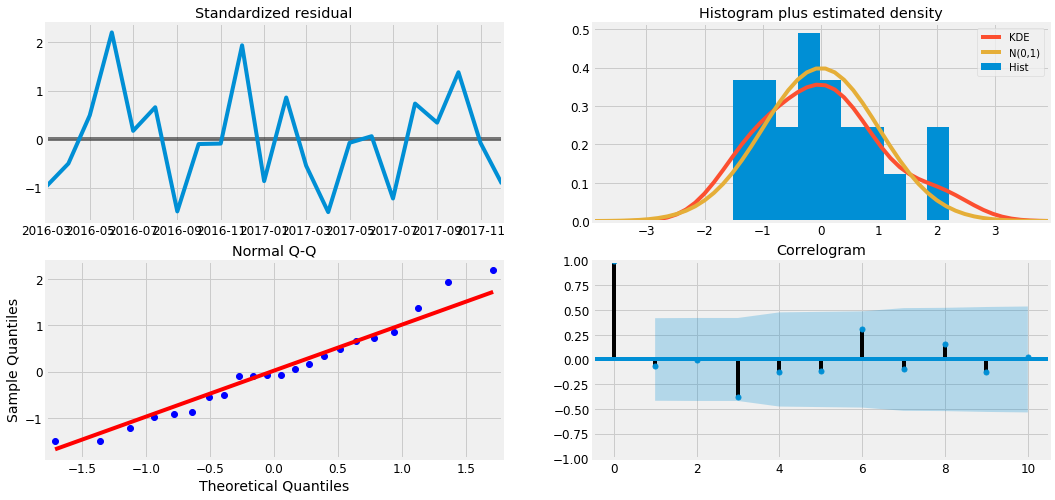

In [15]:
# result diagnostics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts
Check the accuracy of the forecasts by comparing predicted sales to real sasles of the time series. We'll use 2017-01-01 to the end of the data as sample.

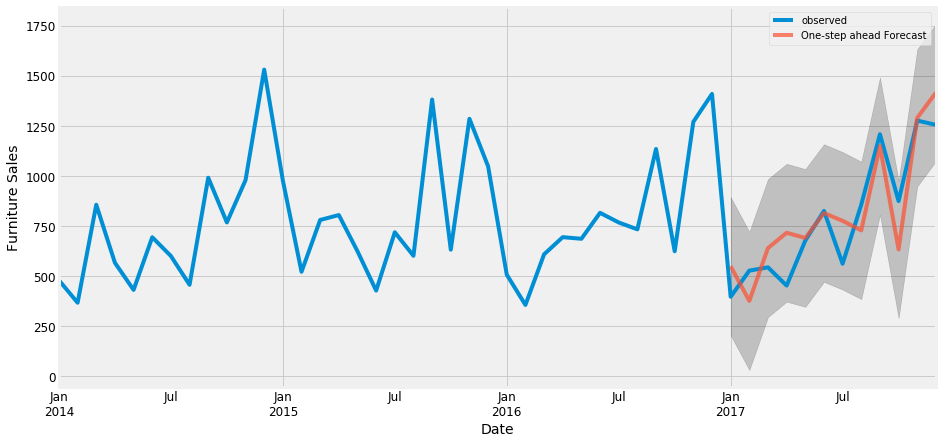

In [16]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [17]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# calculate the mean squeared error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [18]:
# calculate the root mean squared error
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


- In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

- Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

### Producing and visualizing forecasts

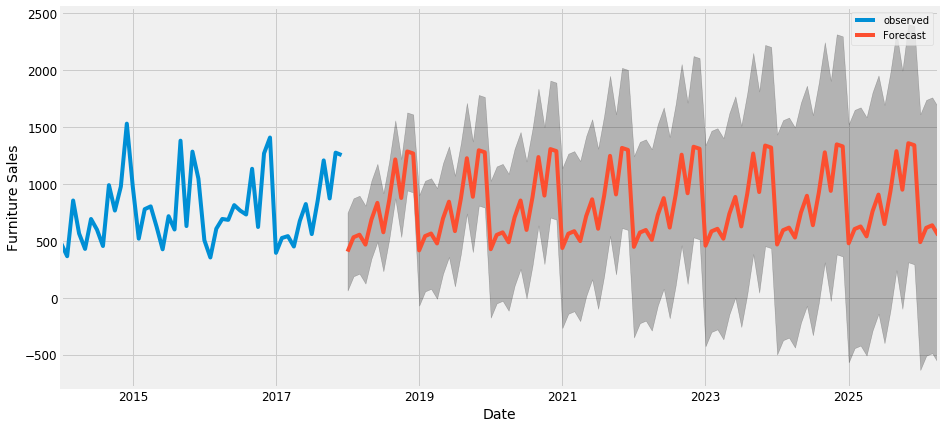

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
# plot
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

- This model clearly captured furniture sales seasonality. 
- As it forecasts further out into the future, it is natural for me to become less confident in the values. 
- This is reflected by the confidence intervals generated by the model.
- The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, I am going to compare time series of furniture and office supplier.

### Time Series of Furniture vs. Office Supplies

In [20]:
# read office supplies data
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

#### Data Exploration

In [22]:
# combine two data frames into one
# make sure to compare two categories' sales in the same period
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


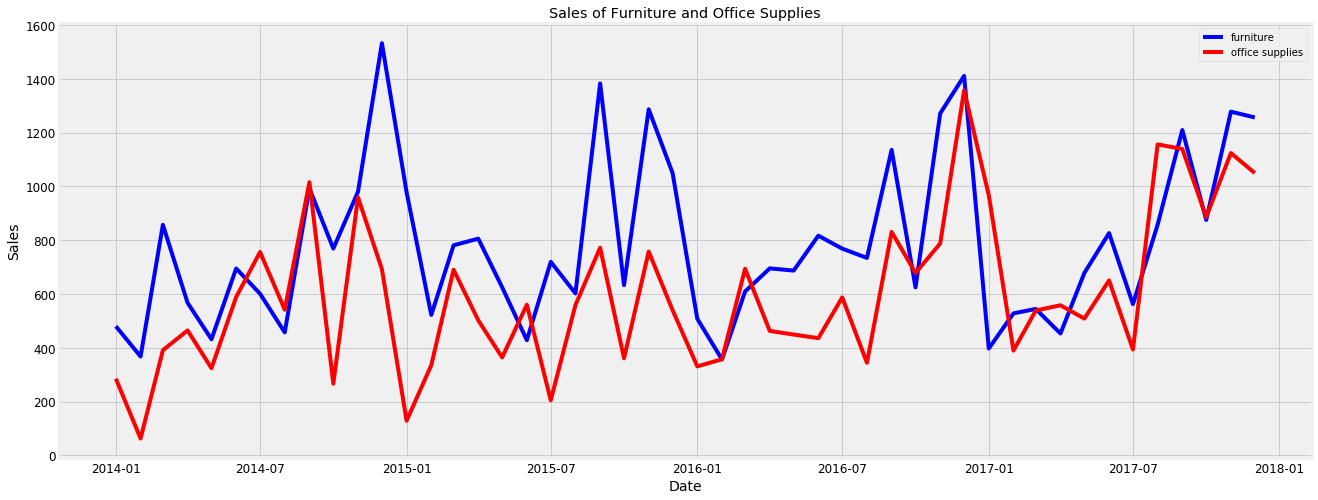

In [23]:
# sales competition
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

Furniture and office supplies shared a similar seasonal pattern.

In [25]:
# find the firstdate when Sale(OS) > Sale(F)
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


### Time Series Modeling

In [44]:
# import time-series forecasting pool Prophet
from fbprophet import Prophet

In [33]:
# rename the coluimns to fit into the model
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x360 with 0 Axes>

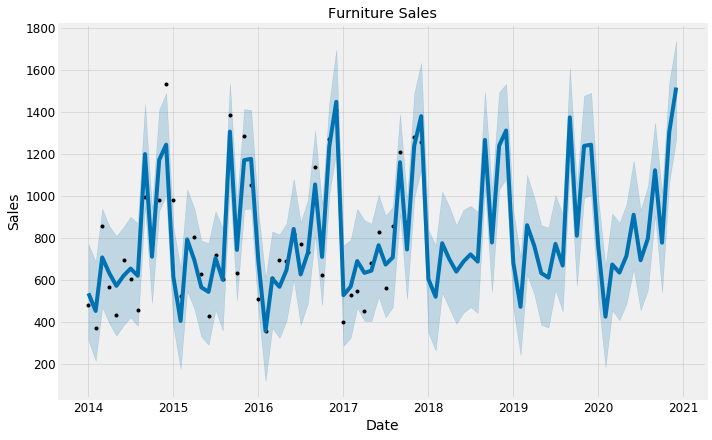

In [45]:
# set forecast period to 36 for both samples
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

# plot furniture
plt.figure(figsize=(18, 5))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x360 with 0 Axes>

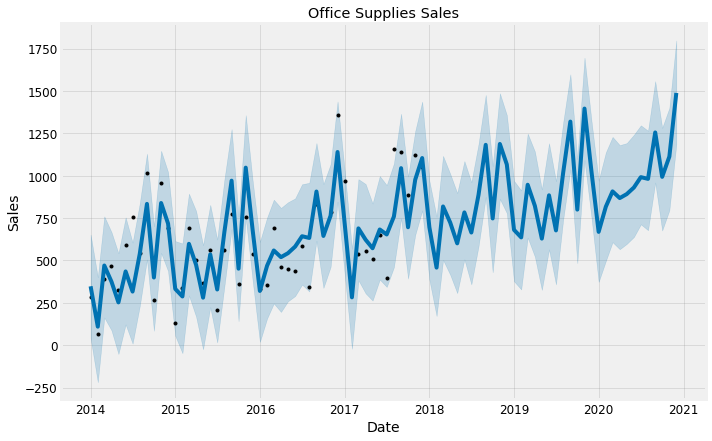

In [46]:
# plot for office supplies
plt.figure(figsize=(18, 5))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

#### Compare Forecasts

In [47]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,311.164055,768.759229,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,214.125208,684.870652,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,470.266933,938.279720,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,391.159845,853.921207,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,332.829097,808.715139,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


Text(0.5, 1.0, 'Furniture vs. Office Supplies Sales Trend')

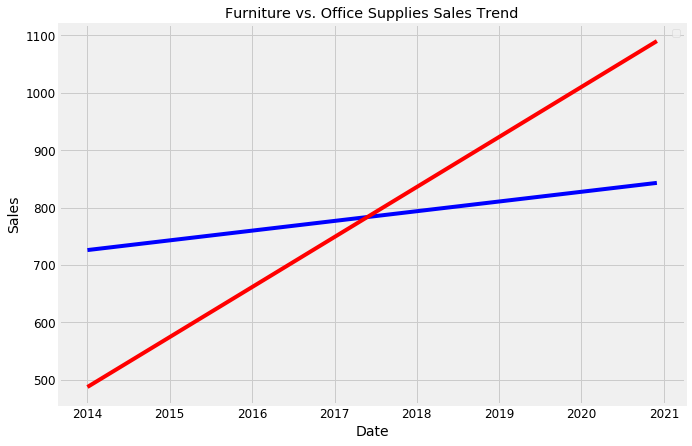

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.legend();
plt.title('Furniture vs. Office Supplies Sales Trend')

Text(0.5, 1.0, 'Furniture vs. Office Supplies Estimate')

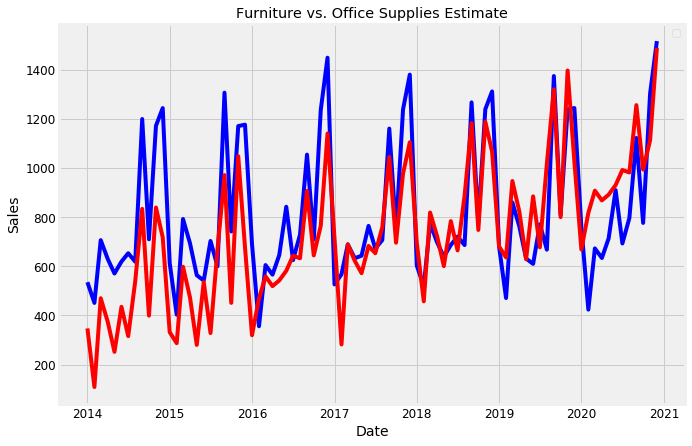

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')